# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from intertidal.utils import load_config, round_date_strings, export_intertidal_rasters
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

## Setup


### Set analysis parameters

In [15]:
study_area = 'Testing'  #1215 #340
## 815: South Gladstone, QLD

## Nidem variables
start_date = '2019'
end_date = '2021'
resolution = 10
crs = "EPSG:3577"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False

## Exposure variables
## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq = '3h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type='start'),
    end=round_date_strings(end_date, round_type='end'),
    freq=modelled_freq)

# Load analysis params from config file
config = load_config(config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

In [ ]:
# # Albers grid cells used to process the analysis
# gridcell_gdf = (
#     gpd.read_file(config['Input files']['grid_path']).to_crs(
#         epsg=4326).set_index('id'))
# gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
# gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Create geom as input for dc.load
# geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
# geom

##### Other options for loading study area

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)

## Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Intertidal elevation

In [5]:
ds, freq, tide_m = elevation(study_area=geom, start_date=start_date, end_date=end_date)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40875,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:41605,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/37089/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:38819,


2023-04-13 00:50:51 INFO Study area testing: Loaded custom study area
2023-04-13 00:50:51 INFO Study area testing: Loading satellite data
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-04-13 00:52:20 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 550/550 [00:02<00:00, 184.13it/s]
2023-04-13 00:52:35 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-04-13 00:52:37 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-04-13 00:52:50 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 705042 to 154507 (21.91%)


100%|██████████| 114/114 [03:18<00:00,  1.74s/it]
2023-04-13 00:56:14 INFO Study area testing: Modelling intertidal elevation and confidence


Processing elevation_low
Processing elevation
Processing elevation_high


2023-04-13 00:56:15 INFO Study area testing: Successfully completed intertidal elevation modelling


### Intertidal extents

#### Always/sometimes/never wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [6]:
ds['extents'] = extents(ds.elevation, freq)

### Intertidal exposure
Calculate exposure using the script function

In [7]:
ds['exposure'], tide_cq = exposure(ds.elevation, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:01<00:00, 78.31it/s]


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [8]:
(ds['lat'], 
 ds['hat'], 
 ds['lot'], 
 ds['hot'], 
 ds['spread'], 
 ds['offset_lowtide'],
 ds['offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [9]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.offset_hightide,
                                         offset_lowtide=ds.offset_lowtide,
                                         distance=250)

Operating in multiple z-value, single array mode


## Plot all layers

In [10]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:               (x: 786, y: 897)
Coordinates:
  * x                     (x) float64 -1.281e+06 -1.281e+06 ... -1.273e+06
  * y                     (y) float64 -2.201e+06 -2.201e+06 ... -2.21e+06
    spatial_ref           int32 3577
    variable              <U4 'ndwi'
Data variables: (12/13)
    elevation_low         (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation             (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation_high        (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation_confidence  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    extents               (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0
    exposure              (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...                    ...
    hat                   (y, x) float64 4.173 4.173 4.173 4.173 ... nan nan nan
    lot                   (y, x) float32 -2.509 -2.509 -2.509 ... nan nan nan
    hot                   (y, x) float32 3.584 3.584 3.584 3.584 ... nan nan nan
    spread                (y, x) float64 72.18 72.18 72.18 72.18 ... nan nan nan
    offset_lowtide        (y, x) float64 20.85 20.85 20.85 20.85 ... nan nan nan
    offset_hightide       (y, x) float64 6.974 6.974 6.974 6.974 ... nan nan nan

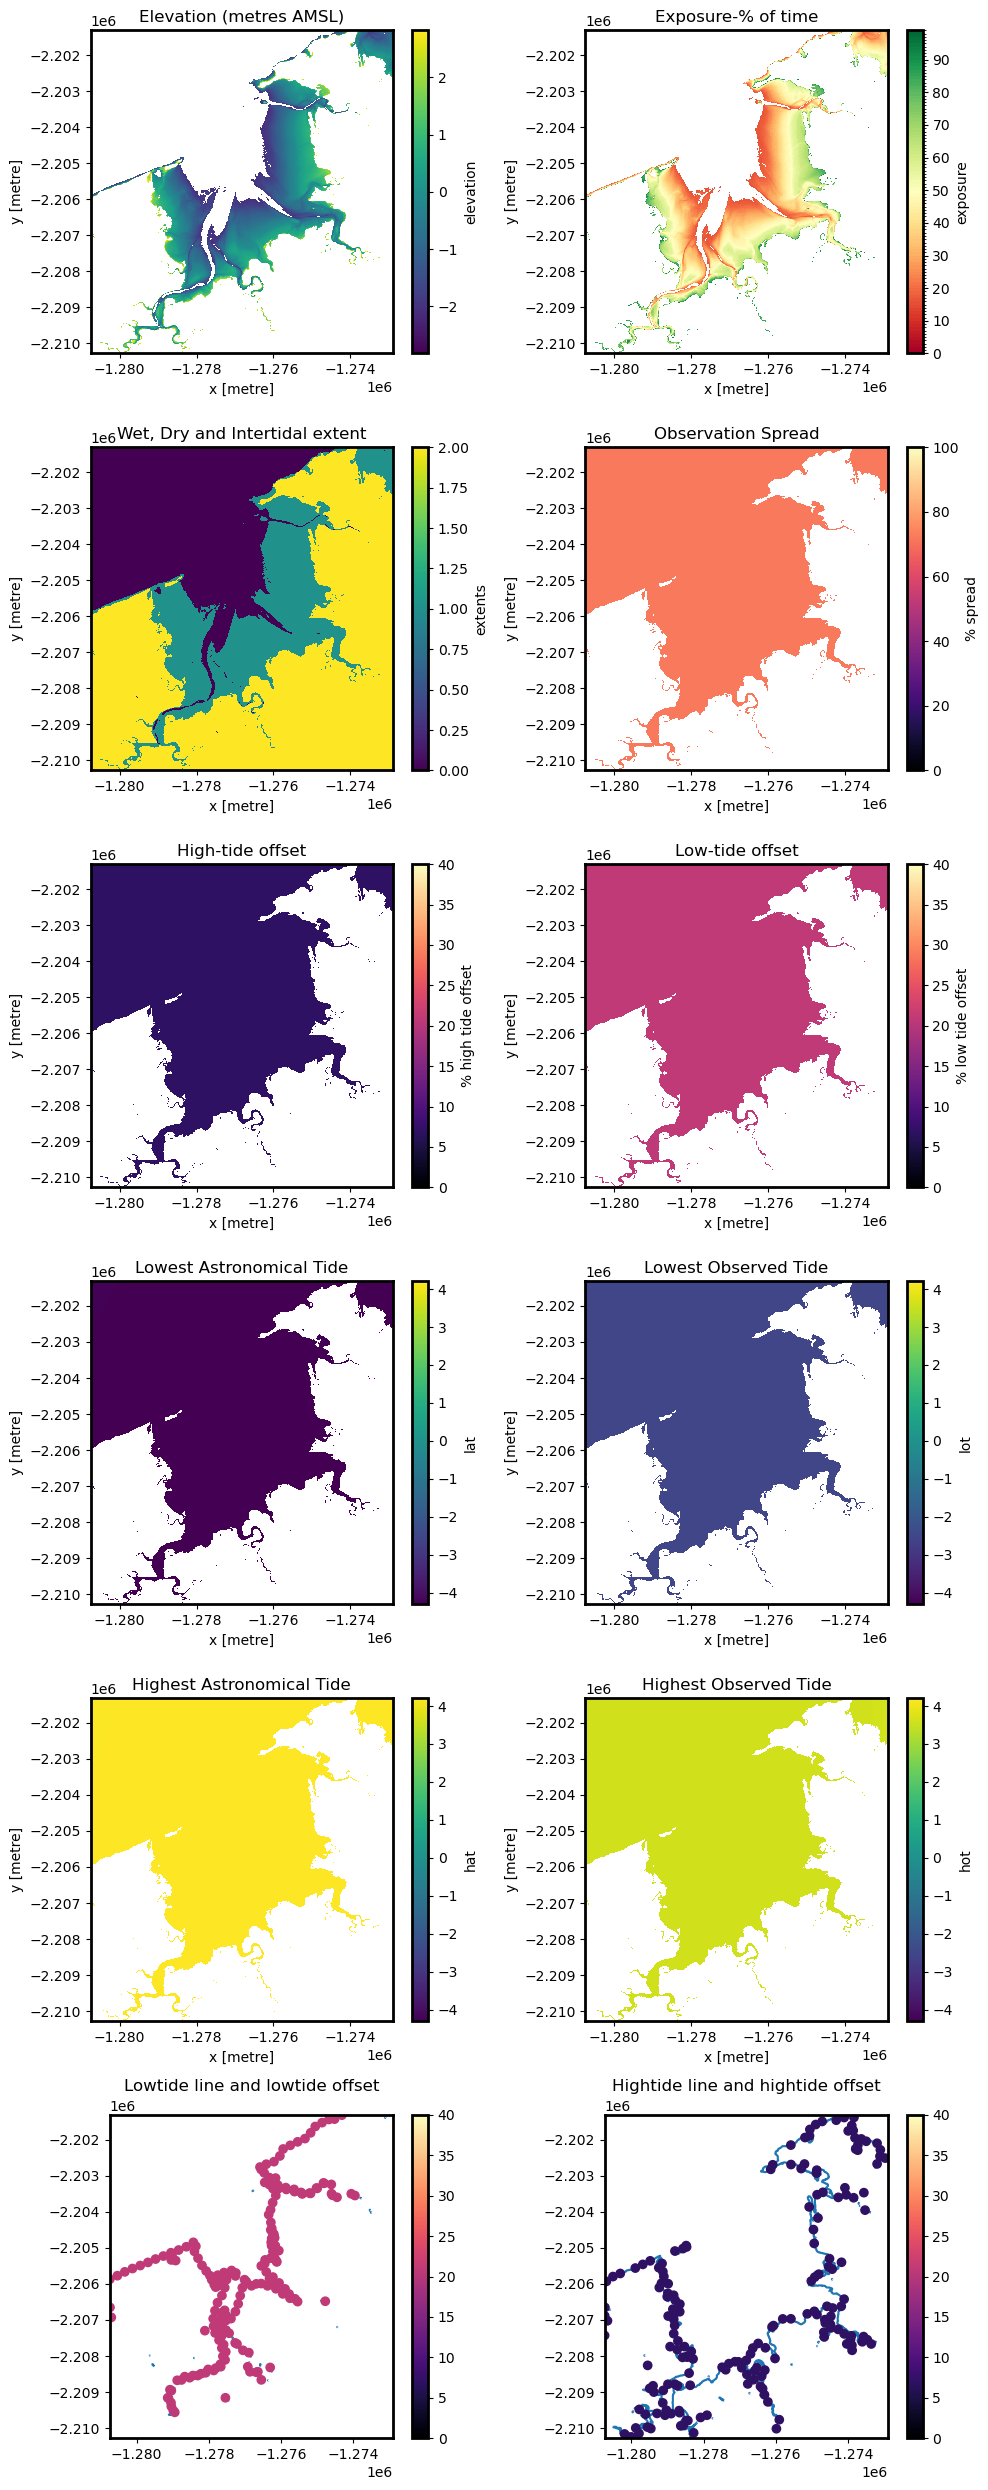

In [11]:
# Set up figure
fig = plt.figure(figsize=(10, 25))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 2)
ax3 = fig.add_subplot(6, 2, 3)
ax4 = fig.add_subplot(6, 2, 4)
ax5 = fig.add_subplot(6, 2, 5)
ax6 = fig.add_subplot(6, 2, 6)
ax7 = fig.add_subplot(6, 2, 7)
ax8 = fig.add_subplot(6, 2, 8)
ax9 = fig.add_subplot(6, 2, 9)
ax10 = fig.add_subplot(6, 2, 10)
ax11 = fig.add_subplot(6, 2, 11)
ax12 = fig.add_subplot(6, 2, 12)

# Plot NIDEM
ds['elevation'].plot(ax=ax1, cmap='viridis')
ax1.set_title('Elevation (metres AMSL)')

# Plot Exposure
ds['exposure'].where(ds['exposure'] > 0).plot(ax=ax2,
                                              cmap='RdYlGn',
                                              levels=np.arange(0, 100, 1))
ax2.set_title('Exposure-% of time')

# Plot the always/sometimes/never wet extents
ds['extents'].astype(np.int16).plot(ax=ax3)
ax3.set_title('Wet, Dry and Intertidal extent')

# Plot the observation spread
ds['spread'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax4, vmin=0, vmax=100, cmap='magma', cbar_kwargs={'label': '% spread'})
ax4.set_title('Observation Spread')

# Plot the high-tide offset
ds['offset_hightide'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax5,
    vmin=0,
    vmax=40,
    cmap='magma',
    cbar_kwargs={'label': '% high tide offset'})
ax5.set_title('High-tide offset')

# Plot the low-tide offset
ds['offset_lowtide'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax6,
    vmin=0,
    vmax=40,
    cmap='magma',
    cbar_kwargs={'label': '% low tide offset'})
ax6.set_title('Low-tide offset')

# Plot the LAT
ds['lat'].where(ds['extents'] != 2).plot(ax=ax7,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax7.set_title('Lowest Astronomical Tide')

# Plot the LOT
ds['lot'].where(ds['extents'] != 2).plot(ax=ax8,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax8.set_title('Lowest Observed Tide')

# Plot the HAT
ds['hat'].where(ds['extents'] != 2).plot(ax=ax9,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax9.set_title('Highest Astronomical Tide')

# Plot the HOT
ds['hot'].where(ds['extents'] != 2).plot(ax=ax10,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax10.set_title('Highest Observed Tide')

# Plot the high and low tidelines with respective offset
ax11.set_title('Lowtide line and lowtide offset')
lowtideline.plot(column='offset_lowtide',
                 legend=True,
                 vmin=0,
                 vmax=40,
                 cmap='magma',
                 ax=ax11,
                 zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)
ax11.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax11.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax12.set_title('Hightide line and hightide offset')
hightideline.plot(column='offset_hightide',
                  legend=True,
                  vmin=0,
                  vmax=40,
                  cmap='magma',
                  ax=ax12,
                  zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)
ax12.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax12.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

fig.tight_layout()
plt.show()

# Export figure
fig.savefig(f'data/interim/{fname}_{start_date}_{end_date}.png')

## Export layers

In [16]:
# Save layers as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"data/interim/{study_area}_{start_date}_{end_date}")

# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")